<a href="https://colab.research.google.com/github/AndriiVasylenkoML/image-preprocessing/blob/main/build_image_preprocessing_model_using_Pytorch_and_integrate_into_your_model_using_ONNX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Export Image Model to ONNX
ResNet50 was my choose to base model. We’ll add dynamic axes to batch size when exporting it. The input to ResNet50 is (3, 224, 224) in the format (C, H, W).

Basic dependencies:


In [ ]:
!pip install torch torchvision onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 22.9 MB/s eta 0:00:00


Gen ONNX model:

In [ ]:
import torch
import torchvision.models as models

model = models.resnet50(pretrained=True)

model.eval()

input_dim = (1, 3, 224, 224)

dummy_input = torch.randn(input_dim)

onnx_path = 'resnet50.onnx'

dynamic = {'input': {0: 'batch'}, 'output': {0: 'batch'}}

torch.onnx.export(model,
                  dummy_input,
                  onnx_path,
                  verbose=True,
                  input_names=['input'],
                  output_names=['output'],
                  dynamic_axes=dynamic,
                  opset_version=17)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 125MB/s]


### 2. Build a Image Preprocessing Model
The model input will be (B, H, W, C) and the output (B, C, H, W). The operations I chose as a demonstration are:

* Permute/Transpose channels
* Normalize
* Resize

We will to explore dynamic axes. Batch, Height and Width will accept any image input, requiring only 3 color channels.



In [ ]:
import torch
import torchvision.transforms as transforms

class TransposeResizeNormalize(torch.nn.Module):
    def __init__(
        self,
        resize,
        mean_values=(127, 127, 127),
        scale_factor=[128, 128, 128]
    ):
        super(TransposeResizeNormalize, self).__init__()
        self.resize = transforms.Resize(
            resize,
            antialias=True,
            interpolation=transforms.InterpolationMode.NEAREST)
        self.normalize = transforms.Normalize(
            mean=mean_values,
            std=scale_factor)

    def forward(self, x):
        x = x.permute(0, 3, 1, 2)
        x = self.resize(x)
        x = self.normalize(x)
        return x

model_prep = TransposeResizeNormalize(resize=(224, 224))

#                         N, H, W, C
dummy_input = torch.randn(1, 123, 555, 3)

dynamic = {'input': {0: 'batch', 1: 'height', 2: 'width'},
            'output': {0 : 'batch'}}

path_export_model_prep = 'prep.onnx'

torch.onnx.export(model_prep,
                  dummy_input,
                  path_export_model_prep,
                  opset_version=17,
                  do_constant_folding=True,
                  input_names = ['input'],
                  output_names=['output'],
                  dynamic_axes=dynamic,
                  verbose=True)



To use onnx-sim is a good pratice to simplify ONNX models.



In [ ]:
!pip install onnxsim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 28.7 MB/s eta 0:00:00


LGTM (good to me)

In [ ]:
!onnxsim prep.onnx prep-sim.onnx

Installing onnxruntime by `/usr/bin/python3 -m pip install onnxruntime`, please wait for a moment..
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 84.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 6.3 MB/s eta 0:00:00
Simplifying...
Finish! Here is the difference:
┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Concat     │ 1              │ 1                │
│ Constant   │ 6              │ 5                │
│ Div        │ 1              │ 1                │
│ Resize     │ 1              │ 1                │
│ Shape      │ 1              │ 1                │
│ Slice      │ 1              │ 1                │
│ Sub        │ 1              │ 1                │
│ Transpose  │ 1              │ 1                │
│ Model Size │ 50.6KiB        │ 27.7KiB          │
└─────

### 3. Compose Models
The ONNX API provides Compose. We only need to make a map between the output of the preprocessing model and the image model. Attention, both models need to be on the same version of IR and Opset.

First, load models:

In [ ]:
import onnx
from onnx import compose
from onnx.compose import merge_models

model = onnx.load('resnet50.onnx')
prep = onnx.load('prep-sim.onnx')

Add prefix to resolve name problems:

In [ ]:
# add prefix, resolve names conflits
prep_with_prefix = compose.add_prefix(prep, prefix="prep_")

model_prep = compose.merge_models(
    prep_with_prefix,
    model,
    io_map=[('prep_output', # output prep model
             'input')])     # input resnet50 model

Serialize:

In [ ]:
onnx.save_model(model_prep, 'resnet_prep.onnx')

### 4. Test

In [ ]:
!pip install onnxruntime

Define a random input:

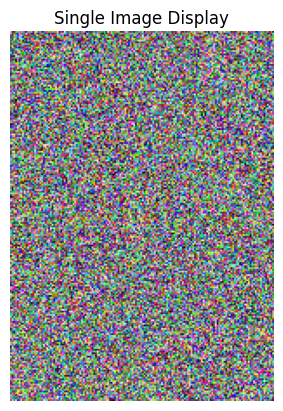

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Rename input variable to avoid keyword conflict
input_data = np.random.rand(213, 152, 3)  # Single RGB image with random values

# Display the single image
plt.imshow(input_data)
plt.axis('off')  # Optional: Hides axis ticks for a cleaner display
plt.title("Single Image Display")
plt.show()

Load and predict!



In [ ]:
import onnxruntime as ort

model_path = 'resnet_prep.onnx'
session = ort.InferenceSession(model_path)
input_name = session.get_inputs()[0].name
outputs = session.run(None, {input_name: input.astype(np.float32)})

In [ ]:
outputs[0].shape

(1, 1000)

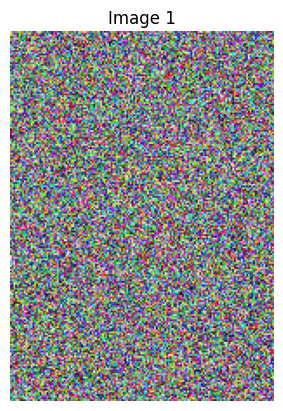

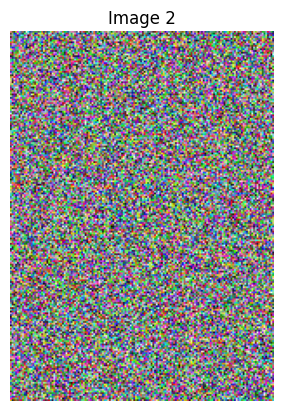

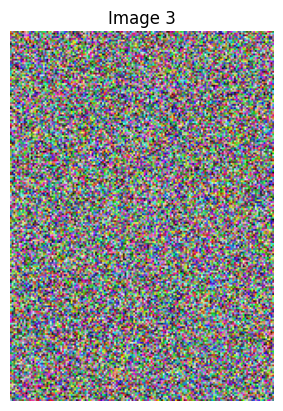

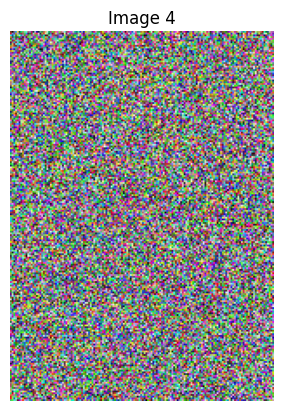

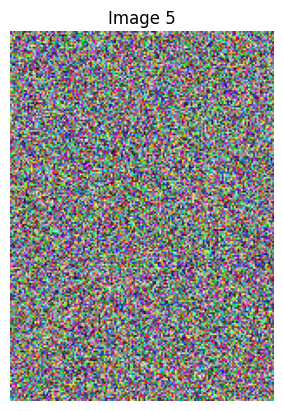

In [ ]:

# Loop over each image in the batch and display
num_images = input_data.shape[0]  # Get the batch size

for i in range(num_images):
    image = input_data[i]  # Extract each image
    plt.imshow(image)
    plt.axis('off')  # Hide axis ticks for each image
    plt.title(f"Image {i+1}")
    plt.show()


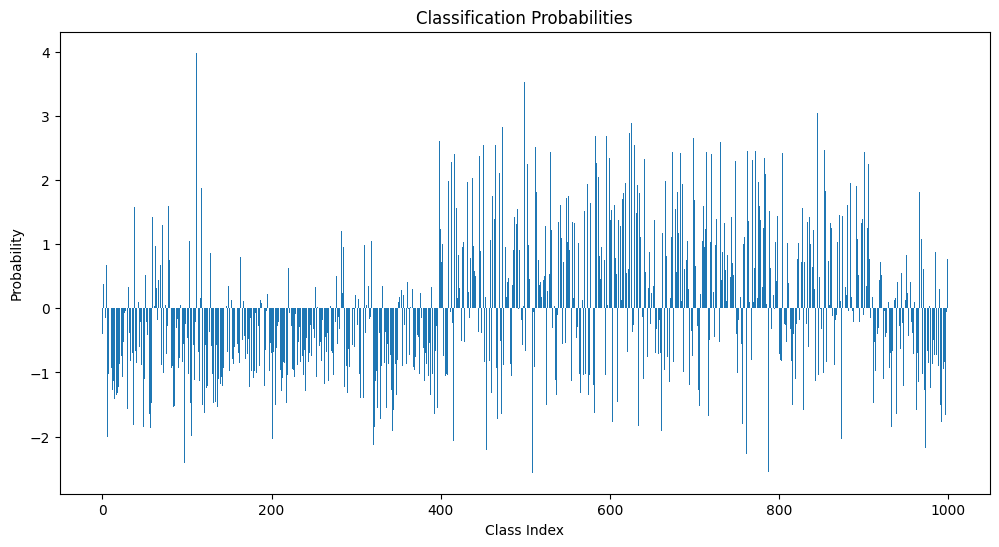

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming outputs[0][0] contains the class probabilities
probabilities = outputs[0][0]

plt.figure(figsize=(12, 6))
plt.bar(range(len(probabilities)), probabilities)
plt.xlabel("Class Index")
plt.ylabel("Probability")
plt.title("Classification Probabilities")
plt.show()
